In [1]:
import geopandas as gpd
import xarray as xr
import rasterio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import gzip
import shutil
import glob
import rioxarray as rxr

In [2]:
import os
from dask.distributed import Client
c = Client(n_workers=os.cpu_count()-2, threads_per_worker=1)

In [3]:
data_dir = "../../../datasets/precipitation_chirps/chirps_tif_daily"

In [4]:
# Read AOI vector file

gha_region = "../../../datasets/gha/gha.shp"

In [5]:
# Read roi polygon
gha_region = gpd.read_file(gha_region)
gha_region.head(4)

,OBJECTID,COUNTRY,area,Shape_Leng,Shape_Area,land_under,geometry
0,1,Burundi,0.0,8.560371,2.193095,None,"POLYGON ((30.36003 -2.35343, 30.36209 -2.35250..."
1,2,Djibouti,0.0,7.874779,1.781569,None,"POLYGON ((42.66339 11.07150, 42.65628 11.07671..."
2,3,Eritrea,0.0,41.125347,10.077064,None,"MULTIPOLYGON (((43.14681 12.71384, 43.14167 12..."
3,4,Ethiopia,0.0,49.028874,92.986294,None,"POLYGON ((41.77824 11.54207, 41.77785 11.51077..."


In [ ]:
# # Extract files 
# chirps_gz_folder = os.path.join(data_dir, 'precipitation_chirps')
# output_folder = os.path.join(data_dir, "precipitation_chirps\chirps_tif")

# # Decompress all .gz files
# for gz_file in os.listdir(chirps_gz_folder):
#     if gz_file.endswith(".gz"):
#         with gzip.open(os.path.join(chirps_gz_folder, gz_file), 'rb') as f_in:
#             with open(os.path.join(data_dir, gz_file[:-3]), 'wb') as f_out:
#                 shutil.copyfileobj(f_in, f_out)
# print("Decompression complete!")


<AxesSubplot: >

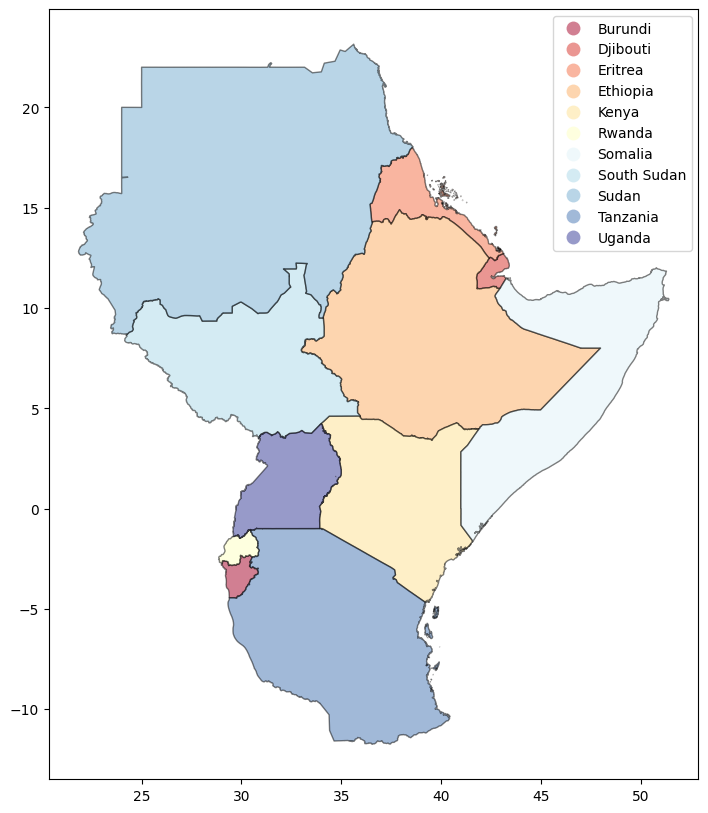

In [118]:
gha_region.plot(figsize=(10, 10), column='COUNTRY', cmap='RdYlBu', alpha=0.5, edgecolor="k", legend=True)

## Precipitation pre-processing

### Read precipitation file

In [6]:
len(os.listdir(data_dir))

7671

In [7]:
''''
Study period: 2004 - 2024
'''
# Path to .tif files
tif_files = glob.glob(data_dir + "/*.tif")
tif_files.sort()

# Extract dates
dates = [
    pd.to_datetime(
        os.path.basename(f).split('chirps-v2.0.')[1].replace('.tif', ''),
        format='%Y.%m.%d'
    )
    for f in tif_files
]

In [8]:
dates[:10]

[Timestamp('2004-01-01 00:00:00'),
 Timestamp('2004-01-02 00:00:00'),
 Timestamp('2004-01-03 00:00:00'),
 Timestamp('2004-01-04 00:00:00'),
 Timestamp('2004-01-05 00:00:00'),
 Timestamp('2004-01-06 00:00:00'),
 Timestamp('2004-01-07 00:00:00'),
 Timestamp('2004-01-08 00:00:00'),
 Timestamp('2004-01-09 00:00:00'),
 Timestamp('2004-01-10 00:00:00')]

In [9]:
# Open all TIFF files using rioxarray and stack them
data_arrays = []
for tif in tif_files:
    da = rxr.open_rasterio(tif, masked=True, chunks=True)  # Open and mask invalid data
    data_arrays.append(da.squeeze(dim="band"))  # Squeeze the "band" dimension if it's single-band


# Combine into a single DataArray
combined_data = xr.concat(data_arrays, dim=pd.Index(dates, name="time"))

# Add meaningful metadata
combined_data.name = "precipitation"
combined_data.attrs["units"] = "mm"

In [10]:
print(combined_data)

<xarray.DataArray 'precipitation' (time: 7671, y: 1600, x: 1500)>
dask.array<concatenate, shape=(7671, 1600, 1500), dtype=float32, chunksize=(1, 1600, 1500), chunktype=numpy.ndarray>
Coordinates:
    band         int64 1
  * x            (x) float64 -19.97 -19.92 -19.87 -19.82 ... 54.88 54.93 54.98
  * y            (y) float64 39.97 39.92 39.87 39.82 ... -39.88 -39.93 -39.98
    spatial_ref  int64 0
  * time         (time) datetime64[ns] 2004-01-01 2004-01-02 ... 2024-12-31
Attributes:
    AREA_OR_POINT:             Area
    TIFFTAG_DATETIME:          2015:09:01 17:11:33
    TIFFTAG_DOCUMENTNAME:      /home/sandbox/chirps/v2.0/daily_downscaled_by_...
    TIFFTAG_IMAGEDESCRIPTION:  IDL TIFF file
    TIFFTAG_RESOLUTIONUNIT:    2 (pixels/inch)
    TIFFTAG_SOFTWARE:          IDL 8.5, Exelis Visual Information Solutions, ...
    TIFFTAG_XRESOLUTION:       100
    TIFFTAG_YRESOLUTION:       100
    scale_factor:              1.0
    add_offset:                0.0
    units:                  

In [11]:
combined_data.time

<xarray.DataArray 'time' (time: 7671)>
array(['2004-01-01T00:00:00.000000000', '2004-01-02T00:00:00.000000000',
       '2004-01-03T00:00:00.000000000', ..., '2024-12-29T00:00:00.000000000',
       '2024-12-30T00:00:00.000000000', '2024-12-31T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
    band         int64 1
    spatial_ref  int64 0
  * time         (time) datetime64[ns] 2004-01-01 2004-01-02 ... 2024-12-31

Text(0.5, 1.0, 'January, 2004 Precipitation (mm)')

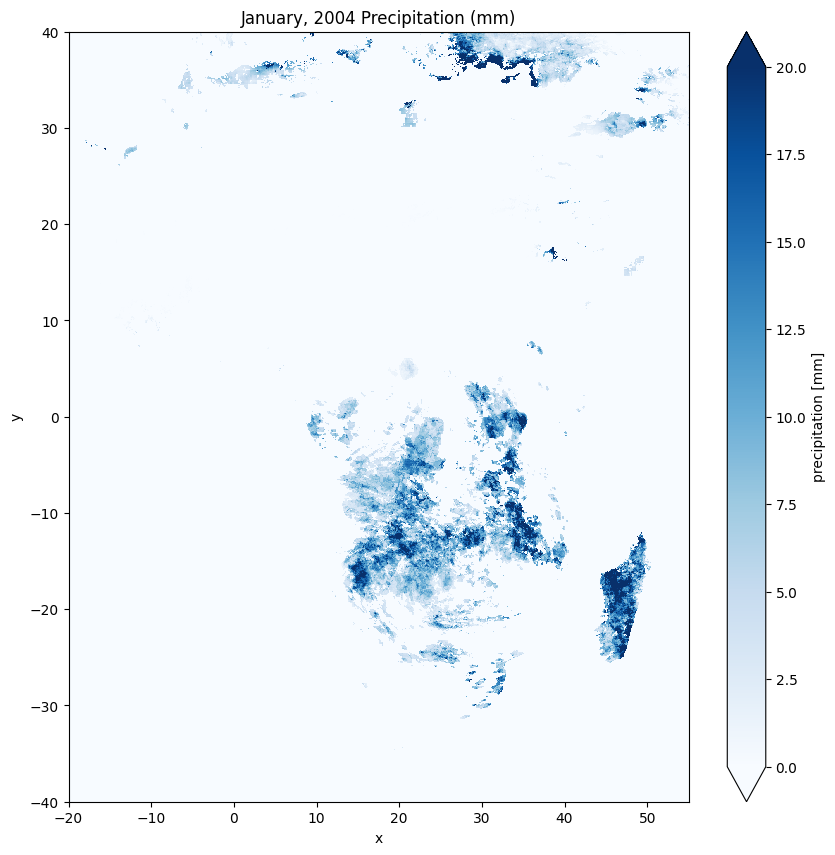

In [120]:
# Plot one month
sample_data = combined_data.isel(time=slice(1,5)).isel(time=0)
sample_data.plot(vmin=0, vmax=20, cmap="Blues", figsize=(10, 10))
plt.title('January, 2004 Precipitation (mm)')

#### Applying Exponential Moving Average

In [81]:
def apply_ema(da, span):
    da.rolling_exp(span, window_type="span").mean()

In [9]:
combined_data.to_netcdf('precip_inal.nc')

In [11]:
# Read precipitation data
precip_chrips = xr.open_dataset('../../datasets/precipitation_chirps/precip_chirps.nc')
precip_chrips

<xarray.Dataset>
Dimensions:        (x: 1500, y: 1600, time: 250)
Coordinates:
    band           int64 ...
  * x              (x) float64 -19.97 -19.92 -19.87 -19.82 ... 54.88 54.93 54.98
  * y              (y) float64 39.97 39.92 39.87 39.82 ... -39.88 -39.93 -39.98
  * time           (time) datetime64[ns] 2004-01-01 2004-02-01 ... 2024-10-01
Data variables:
    spatial_ref    int64 ...
    precipitation  (time, y, x) float32 ...

### Clip the study area

In [12]:
# TODO: Clip data to study area

# Set spatial dimensions and CRS
data = combined_data.rio.set_spatial_dims(x_dim="x", y_dim="y", inplace=True)
data = data.rio.write_crs("epsg:4326", inplace=True)

# Load the shapefile using geopandas
gdf = gha_region.to_crs(data.rio.crs)

# Extract geometries from the GeoDataFrame
geometries = gdf.geometry

# Clip the dataset using the geometries
precipitaion_gha = data.rio.clip(geometries, gdf.crs)

In [13]:
print(precipitaion_gha)

<xarray.DataArray 'precipitation' (time: 7671, y: 698, x: 591)>
dask.array<getitem, shape=(7671, 698, 591), dtype=float32, chunksize=(1, 698, 591), chunktype=numpy.ndarray>
Coordinates:
    band         int64 1
  * x            (x) float64 21.88 21.93 21.98 22.03 ... 51.23 51.28 51.33 51.38
  * y            (y) float64 23.12 23.07 23.02 22.97 ... -11.63 -11.68 -11.73
  * time         (time) datetime64[ns] 2004-01-01 2004-01-02 ... 2024-12-31
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:             Area
    TIFFTAG_DATETIME:          2015:09:01 17:11:33
    TIFFTAG_DOCUMENTNAME:      /home/sandbox/chirps/v2.0/daily_downscaled_by_...
    TIFFTAG_IMAGEDESCRIPTION:  IDL TIFF file
    TIFFTAG_RESOLUTIONUNIT:    2 (pixels/inch)
    TIFFTAG_SOFTWARE:          IDL 8.5, Exelis Visual Information Solutions, ...
    TIFFTAG_XRESOLUTION:       100
    TIFFTAG_YRESOLUTION:       100
    scale_factor:              1.0
    add_offset:                0.0
    units:                     mm


In [14]:
#Save file to disk
precipitaion_gha.to_netcdf(os.path.join("../../../datasets/precipitation_chirps/", 'daily_precipitation_gha.nc'))

2025-03-24 03:32:00,867 - distributed.worker - ERROR - Worker stream died during communication: tcp://127.0.0.1:34239
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/distributed/comm/core.py", line 328, in connect
    handshake = await asyncio.wait_for(comm.read(), time_left())
  File "/usr/lib/python3.8/asyncio/tasks.py", line 501, in wait_for
    raise exceptions.TimeoutError()
asyncio.exceptions.TimeoutError

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/distributed/worker.py", line 2031, in gather_dep
    response = await get_data_from_worker(
  File "/usr/local/lib/python3.8/dist-packages/distributed/worker.py", line 2820, in get_data_from_worker
    return await retry_operation(_get_data, operation="get_data_from_worker")
  File "/usr/local/lib/python3.8/dist-packages/distributed/utils_comm.py", line 383, in retry_operation
    return await r

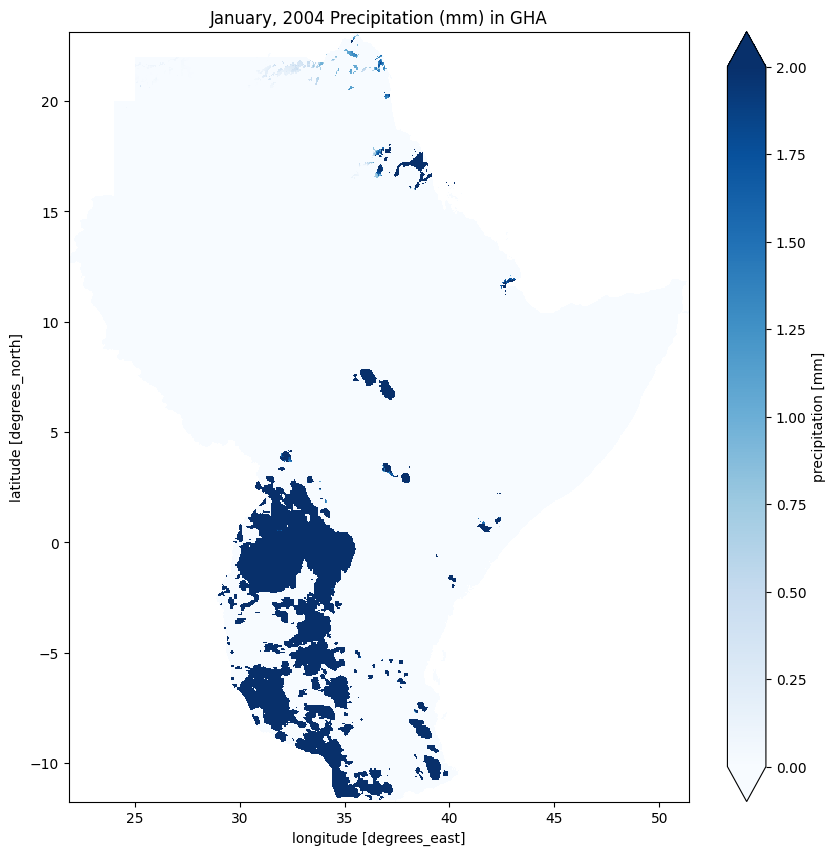

In [15]:
# Plot one month
sample_data = precipitaion_gha.isel(time=slice(1,5)).isel(time=0)
sample_data.plot(vmin=0, vmax=2, cmap="Blues", figsize=(10, 10))
plt.title('January, 2004 Precipitation (mm) in GHA')
plt.show()

### Calculate baseline average

#### Process climatology

In [10]:
# Calculate monthly climatology (mean for each month over the years)
precipitation_clim = combined_data.groupby("time.month").mean("time")

In [11]:
# Calculate anomalies
precipitation_anomalies = combined_data.groupby("time.month") - precipitation_clim

### Standardize the anomalies

In [ ]:
# Calculate the standard deviation for each month over the years
precipitation_std = combined_data.groupby("time.month").std("time")

# Calculate standardized anomalies
standardized_anomalies = precipitation_anomalies / precipitation_std

In [35]:
# Plot standardized anomalies for a sample month
sample_standardized_anomalies = standardized_anomalies.isel(time=0)
sample_standardized_anomalies

<xarray.DataArray 'precipitation' (y: 1600, x: 1500, month: 12)>
array([[[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        ...,
        [5.24686  , 5.2875557, 4.1239796, ..., 7.7671957, 5.7902856,
         3.4505675],
        [5.91887  , 5.964347 , 4.645369 , ..., 9.236686 , 6.583293 ,
         3.871968 ],
        [5.740989 , 5.645746 , 4.3100705, ..., 9.203517 , 6.151303 ,
         3.6599796]],

       [[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
...
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]],

       [[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        ...,
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]]], dtype=float32)
Coordinates:
    band         int64 1
  * x            (x) float64 -19.97 -19.92 -19.87 -19.82 ... 54.88 54.93 54.98
  * y            (y) float64 39.97 39.92 39.87 39.82 ... -39.88 -39.93 -39.98
    spatial_ref  int64 0
    time         datetime64[ns] 2004-04-01
  * month        (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

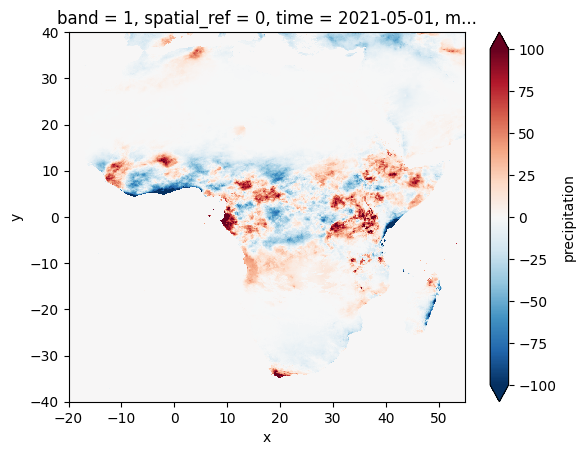

In [40]:
precipitation_anomalies.isel(time=2).plot(vmax=100)

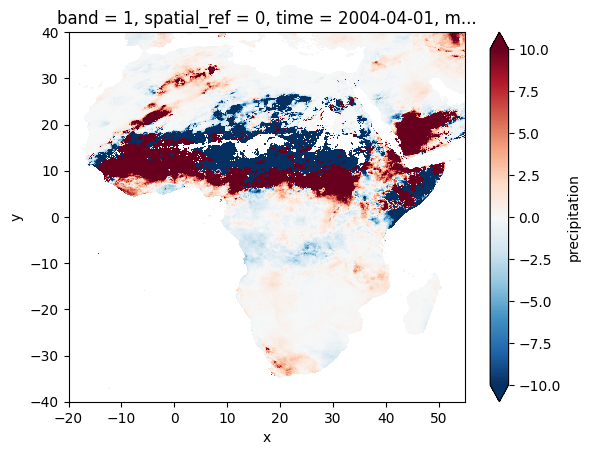

In [46]:
sample_standardized_anomalies.isel(month=0).plot(vmax=10)

In [53]:
stan = []
stan = (sample_standardized_anomalies.isel(month=0).values)
stan

array([[      nan,       nan,       nan, ..., 5.24686  , 5.91887  ,
        5.740989 ],
       [      nan,       nan,       nan, ..., 5.217047 , 5.6160555,
        5.5057893],
       [      nan,       nan,       nan, ..., 5.1241198, 5.3088107,
        5.8705044],
       ...,
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan]], dtype=float32)

#### TODO

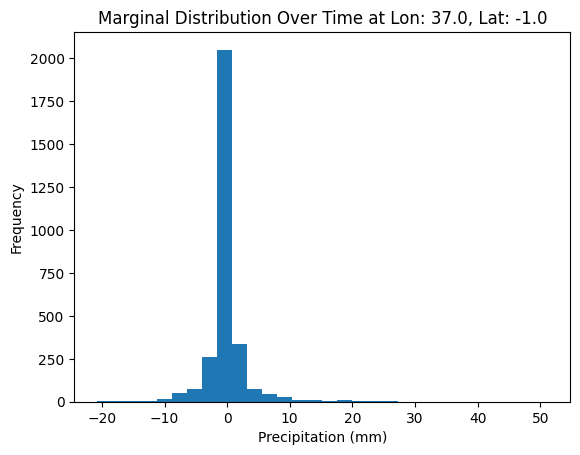

In [89]:
# TODO: Implement fitting marginal distribution to the data

# Select a specific location
lon, lat = 37.0, -1.0  # Example coordinates

# Extract time series for the location
time_series = standardized_anomalies.sel(x=lon, y=lat, method="nearest")

# Plot histogram (marginal distribution over time)
time_series.plot.hist(bins=30)
plt.title(f"Marginal Distribution Over Time at Lon: {lon}, Lat: {lat}")
plt.xlabel("Precipitation (mm)")
plt.ylabel("Frequency")
plt.show()



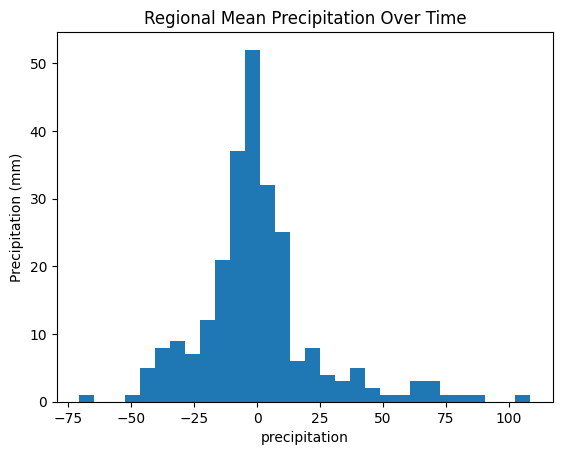

In [91]:
# Subset data for a bounding box (e.g., Greater Horn of Africa)
region = precipitation_anomalies.sel(x=slice(33, 43), y=slice(5, -5))

# Calculate mean precipitation over space or time within the region
region_mean_time = region.mean(dim=["x", "y"])
region_mean_time.plot.hist(bins=30)
plt.title("Regional Mean Precipitation Over Time")
plt.ylabel("Precipitation (mm)")
plt.show()


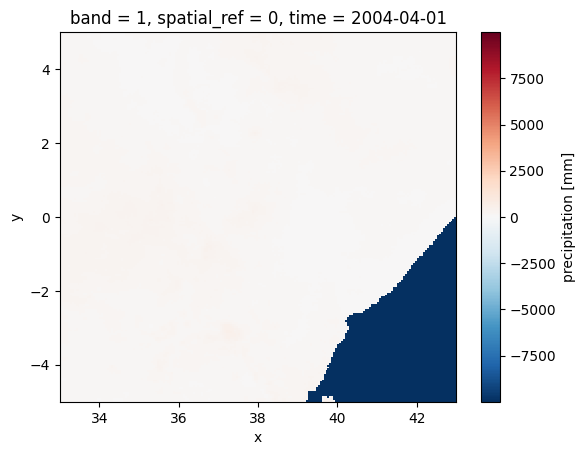

In [81]:
region.isel(time=0).plot()

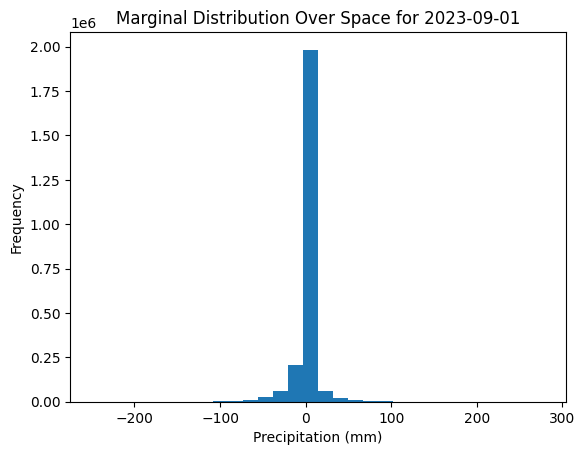

In [93]:
# Select a specific time point
specific_time = "2023-09-01"

# Extract spatial precipitation data
spatial_data = precipitation_anomalies.sel(time=specific_time)

# Flatten the data and plot histogram
spatial_data.plot.hist(bins=30)
plt.title(f"Marginal Distribution Over Space for {specific_time}")
plt.xlabel("Precipitation (mm)")
plt.ylabel("Frequency")
plt.show()
